# WGAN-GP Implementation
This notebook implements a Wasserstein GAN with Gradient Penalty (WGAN-GP) using architectures inspired by the Locatello VAE model.

In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import get_dataset
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import torch
import gc

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache emptied.")
else:
    print("CUDA is not available.")

CUDA cache emptied.


In [42]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm

class Generator(nn.Module):
    def __init__(self, img_size, latent_dim=10, use_batchnorm: bool = False):
        """
        Args
        ----
        img_size      : tuple  (C, H, W) – must be (C, 64, 64) in your current setup
        latent_dim    : int    length of latent z-vector
        use_batchnorm : bool   if True add BatchNorm1d / BatchNorm2d after every
                               linear / ConvTranspose2d layer except the output
        """
        super().__init__()
        self.use_bn = use_batchnorm
        n_chan, kernel = img_size[0], 4
        self.reshape = (64, kernel, kernel)     # feature map shape before up-sampling
        self.latent_dim = latent_dim

        # -------- fully-connected “stem” --------
        self.lin1 = nn.Linear(latent_dim, 256, bias=not self.use_bn)
        self.bn_lin1 = nn.BatchNorm1d(256, momentum=0.8) if self.use_bn else nn.Identity()

        self.lin2 = nn.Linear(256, np.prod(self.reshape))

        # -------- transposed-conv “decoder” --------
        kwargs = dict(stride=2, padding=1, bias=not self.use_bn)
        self.convT1 = nn.ConvTranspose2d(64, 64, kernel, **kwargs)
        self.bn1    = nn.BatchNorm2d(64,  momentum=0.8) if self.use_bn else nn.Identity()

        self.convT2 = nn.ConvTranspose2d(64, 32, kernel, **kwargs)
        self.bn2    = nn.BatchNorm2d(32,  momentum=0.8) if self.use_bn else nn.Identity()

        self.convT3 = nn.ConvTranspose2d(32, 32, kernel, **kwargs)
        self.bn3    = nn.BatchNorm2d(32,  momentum=0.8) if self.use_bn else nn.Identity()

        # last layer keeps bias so pixels can shift freely; no BN here
        self.convT4 = nn.ConvTranspose2d(32, n_chan, kernel, stride=2, padding=1)

    # -------- forward pass --------
    def forward(self, z):
        b = z.size(0)
        x = F.leaky_relu(self.bn_lin1(self.lin1(z)), 0.2)
        x = F.leaky_relu(self.lin2(x), 0.2)
        x = x.view(b, *self.reshape)

        x = F.leaky_relu(self.bn1(self.convT1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.convT2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.convT3(x)), 0.2)
        return torch.sigmoid(self.convT4(x))     # (b, C, 64, 64)

# Discriminator (based on Locatello's Encoder) - Refactored to handle any number of channels
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size

        kernel_size = 4
        n_chan = self.img_size[0]  # Automatically get number of channels from img_size

        assert_str = "This architecture requires 64x64 inputs."
        assert self.img_size[-2] == self.img_size[-1] == 64, assert_str

        cnn_kwargs = dict(stride=2, padding=1)
        self.conv1 = nn.Conv2d(n_chan, 32, kernel_size, **cnn_kwargs)
        self.conv2 = nn.Conv2d(32, 32, kernel_size, **cnn_kwargs)
        self.conv3 = nn.Conv2d(32, 64, kernel_size, **cnn_kwargs)
        self.conv4 = nn.Conv2d(64, 64, kernel_size, **cnn_kwargs)

        self.lin = nn.Linear(int((64/(2**4))**2 * 64), 256)
        self.output_layer = nn.Linear(256, 1) # Output a single value for real/fake

    def forward(self, x):
        batch_size = x.size(0)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = x.view((batch_size, -1))
        x = F.leaky_relu(self.lin(x), 0.2)
        return self.output_layer(x)

# Gradient Penalty function
def calculate_gradient_penalty(discriminator, real_images, fake_images, device):
    alpha = torch.rand(real_images.size(0), 1, 1, 1).to(device)
    interpolated_images = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)
    
    interpolated_output = discriminator(interpolated_images)
    
    gradients = torch.autograd.grad(outputs=interpolated_output, inputs=interpolated_images,
                                    grad_outputs=torch.ones_like(interpolated_output),
                                    create_graph=True, retain_graph=True)[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, 1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty

In [5]:
def train_wgan_gp(gen, disc, gen_optimizer, disc_optimizer, data_loader, num_epochs, critic_iterations, lambda_gp, device, dataset_name="Dataset"):
    print(f"Starting {dataset_name} WGAN-GP Training...")
    for epoch in range(num_epochs):
        progress_bar = tqdm(data_loader, desc=f"{dataset_name} Epoch {epoch+1}/{num_epochs}")
        for i, (real_images, _) in enumerate(progress_bar):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            # Train Discriminator
            for _ in range(critic_iterations):
                disc_optimizer.zero_grad()
                
                # Real images
                real_output = disc(real_images)
                
                # Fake images
                z = torch.randn(batch_size, gen.latent_dim).to(device)
                fake_images = gen(z).detach()
                fake_output = disc(fake_images)
                
                # Calculate gradient penalty
                gp = calculate_gradient_penalty(disc, real_images, fake_images, device)
                
                # Discriminator loss
                d_loss = -torch.mean(real_output) + torch.mean(fake_output) + lambda_gp * gp
                d_loss.backward()
                disc_optimizer.step()
                
            # Train Generator
            gen_optimizer.zero_grad()
            z = torch.randn(batch_size, gen.latent_dim).to(device)
            fake_images = gen(z)
            output = disc(fake_images)
            g_loss = -torch.mean(output) # Generator tries to make fake images look real
            g_loss.backward()
            gen_optimizer.step()
                
            # Update tqdm postfix with current losses
            if (i+1) % 100 == 0:
                progress_bar.set_postfix(D_Loss=d_loss.item(), G_Loss=g_loss.item())

    print(f"{dataset_name} training complete!")


In [6]:
import matplotlib.pyplot as plt

def visualize_generated_images(generator, latent_dim, device, num_images_to_show=16, title="Generated Images", is_grayscale=False):
    z_sample = torch.randn(num_images_to_show, latent_dim).to(device)
    with torch.no_grad():
        generated_images = generator(z_sample).cpu()

    fig = plt.figure(figsize=(8, 8))
    for i in range(num_images_to_show):
        ax = fig.add_subplot(4, 4, i + 1)
        img = generated_images[i].permute(1, 2, 0).numpy() if not is_grayscale else generated_images[i].squeeze().numpy()
        ax.imshow(img, cmap='gray' if is_grayscale else None)
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

def compare_real_vs_generated_images(generator, data_loader, latent_dim, device, num_images_to_show=8, title="Real vs Generated Images", is_grayscale=False):
    fig, axes = plt.subplots(2, num_images_to_show, figsize=(16, 4))

    real_batch = next(iter(data_loader))[0][:num_images_to_show]

    with torch.no_grad():
        z_sample = torch.randn(num_images_to_show, latent_dim).to(device)
        fake_batch = generator(z_sample).cpu()

    for i in range(num_images_to_show):
        axes[0, i].imshow(real_batch[i].permute(1, 2, 0).numpy() if not is_grayscale else real_batch[i].squeeze().numpy(), cmap='gray' if is_grayscale else None)
        axes[0, i].set_title('Real' if i == 0 else '')
        axes[0, i].axis('off')

    for i in range(num_images_to_show):
        axes[1, i].imshow(fake_batch[i].permute(1, 2, 0).numpy() if not is_grayscale else fake_batch[i].squeeze().numpy(), cmap='gray' if is_grayscale else None)
        axes[1, i].set_title('Generated' if i == 0 else '')
        axes[1, i].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize generated images for 3dShapes


# Dataset

## 3dShapes

In [7]:
Shapes3D = get_dataset("shapes3d")
shapes3d_dataset = Shapes3D(selected_factors='all', not_selected_factors_index_value=None)

num_workers_3dshapes = 4
data_loader = DataLoader(shapes3d_dataset, 
                         batch_size=64, 
                         shuffle=True, 
                         num_workers=num_workers_3dshapes, 
                         pin_memory=True,
                         persistent_workers=True
                         )

In [43]:
# Initialize Generator and Discriminator
img_size = (3, 64, 64)  # Assuming RGB images of size 64x64
gen = Generator(img_size, latent_dim=10, use_batchnorm=True).to(device)
disc = Discriminator(img_size).to(device)

# Optimizers
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.9))
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=0.0001, betas=(0.5, 0.9))

# Training parameters
num_epochs = 10
critic_iterations = 1 # Discriminator steps per generator step
lambda_gp = 10 # Gradient penalty lambda

In [44]:
train_wgan_gp(gen, disc, gen_optimizer, disc_optimizer, data_loader, num_epochs, critic_iterations, lambda_gp, device, dataset_name="3dShapes")

Starting 3dShapes WGAN-GP Training...


3dShapes Epoch 10/10: 100%|██████████| 7500/7500 [01:40<00:00, 74.56it/s, D_Loss=-2.26, G_Loss=-9.8] 

3dShapes training complete!


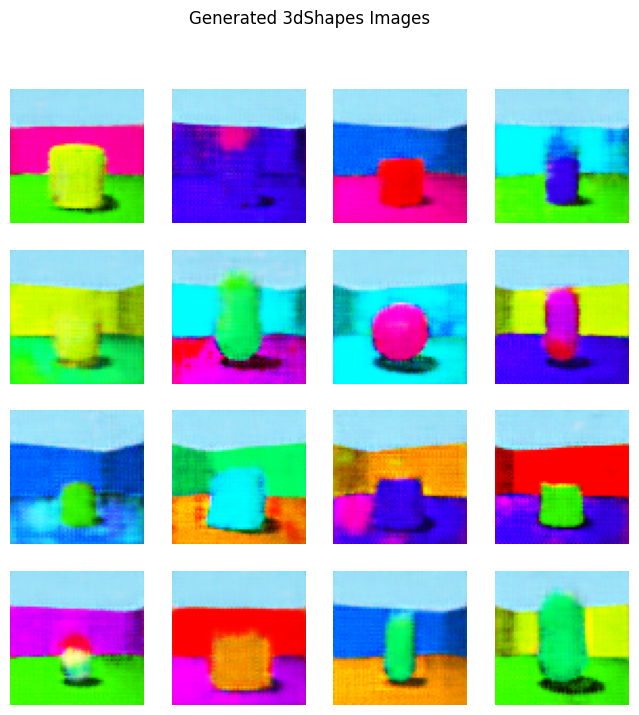

In [48]:
visualize_generated_images(gen, gen.latent_dim, device, title="Generated 3dShapes Images")

## DSprites

In [49]:
# Load DSprites dataset
dsprites_img_size = (1, 64, 64)  # Single-channel images of size 64x64
DSprites = get_dataset("dsprites")
dsprites_dataset = DSprites(selected_factors='all', not_selected_factors_index_value=None)

num_workers_dsprites = 4
dsprites_data_loader = DataLoader(dsprites_dataset, 
                                 batch_size=64, 
                                 shuffle=True, 
                                 num_workers=num_workers_dsprites, 
                                 pin_memory=True,
                                 persistent_workers=True
                                 )

In [50]:
# Initialize Generator and Discriminator for DSprites
dsprites_gen = Generator(dsprites_img_size, latent_dim=10, use_batchnorm=True).to(device)
dsprites_disc = Discriminator(dsprites_img_size).to(device)

# Optimizers for DSprites models
dsprites_gen_optimizer = torch.optim.Adam(dsprites_gen.parameters(), lr=0.0001, betas=(0.5, 0.9))
dsprites_disc_optimizer = torch.optim.Adam(dsprites_disc.parameters(), lr=0.0001, betas=(0.5, 0.9))

# Training parameters
dsprites_num_epochs = 10
dsprites_critic_iterations = 1
dsprites_lambda_gp = 5

In [51]:
# Train dSprites WGAN-GP
train_wgan_gp(dsprites_gen, dsprites_disc, dsprites_gen_optimizer, dsprites_disc_optimizer, dsprites_data_loader, dsprites_num_epochs, dsprites_critic_iterations, dsprites_lambda_gp, device, dataset_name="dSprites")

Starting dSprites WGAN-GP Training...


dSprites Epoch 10/10: 100%|██████████| 11520/11520 [02:28<00:00, 77.53it/s, D_Loss=-.114, G_Loss=-38.3] 

dSprites training complete!


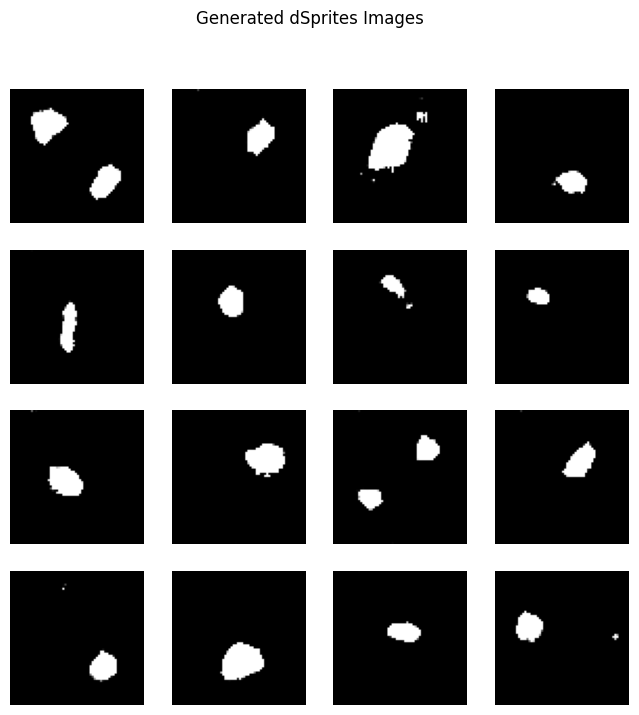

In [22]:
# Visualize generated images for dSprites
visualize_generated_images(dsprites_gen, dsprites_gen.latent_dim, device, title="Generated dSprites Images", is_grayscale=True)